In [128]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import numba
from collections import Counter
import math
import sklearn
import sklearn.metrics
import sklearn.ensemble
import scipy.sparse
import keras
import sys
import pickle
sys.path += ["../test"]
from train_clustering import encode_triu, decode_triu
from train_regression import get_unique_X_y

In [2]:
@numba.njit
def get_types_in_block(X, y, blk):
    return [int(x) for x in sorted(X[y==blk, 0])]

Load all elements

In [ ]:
all_sgs = []

num_clusters = []
num_tracks = []
num_cands = []
num_blocks = []

for fi in glob.glob("../data/TTbar/*ev*.npz")[:500]:
    fi = open(fi, "rb")
    data = np.load(fi)
    
    #list of PF input elements in the event
    X = data["elements"]
    
    #tracks have type=1
    num_clusters += [np.sum(X[:, 0] != 1)]
    num_tracks += [np.sum(X[:, 0] == 1)]
    
    #unique ID for each cluster/block of elements that the PFAlgo considered independently
    #this can be considered as the target output of an improved PFBlockAlgo
    y = data["element_block_id"]
    num_blocks += [len(np.unique(y))]

    #List of candidates produced in the event.
    #This can be considered as the output of PFAlgo
    cands = data["candidates"]
    num_cands += [len(cands)]

    #get the types of the elements for each cluster/block
    sgs = [tuple(get_types_in_block(X, y, blk)) for blk in np.unique(y)]
    all_sgs += sgs

In [ ]:
plt.hist(num_clusters, bins=np.linspace(0,5000,100), label="clusters", alpha=0.5);
plt.hist(num_tracks, bins=np.linspace(0,5000,100), label="tracks", alpha=0.5);
plt.legend()
plt.xlabel("number of elements")
plt.ylabel("number of events")

In [ ]:
plt.hist(num_cands, bins=np.linspace(0,4000,100));
plt.xlabel("number of candidates")
plt.ylabel("number of events")

In [ ]:
plt.hist(num_blocks, bins=np.linspace(0,4000,100));
plt.xlabel("number of miniblocks")
plt.ylabel("number of events")

Now we look at the number of blocks of a certain size.

In [ ]:
block_sizes = Counter([len(sg) for sg in all_sgs])
print("block sizes", block_sizes)

In [ ]:
plt.hist([len(sg) for sg in all_sgs], bins=np.linspace(0,100,101));
plt.xlabel("block size")
plt.ylabel("Number of blocks")

In [ ]:
plt.hist([len(sg) for sg in all_sgs], bins=np.linspace(0,100,101));
plt.yscale("log")
plt.xlabel("block size")
plt.ylabel("number of blocks")

Let's look at what the blocks f size, 1, 2, 3 and 4 are made of.

1-element blocks Counter({'8': 275, '1': 211, '9': 170, '4': 134, '3': 106, '2': 90, '5': 54})
2-element blocks Counter({'8,9': 218, '1,5': 37, '1,4': 20, '5,11': 2})
3-element blocks Counter({'1,1,5': 21, '1,4,5': 3})
4-element blocks Counter({'1,1,1,5': 8, '1,1,4,5': 5, '1,4,4,5': 1})


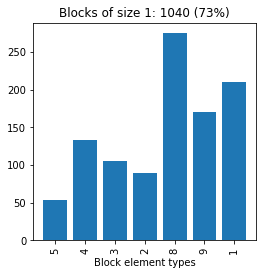

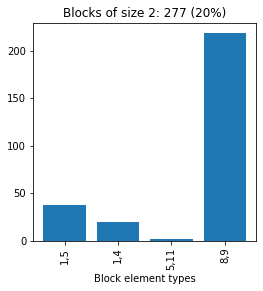

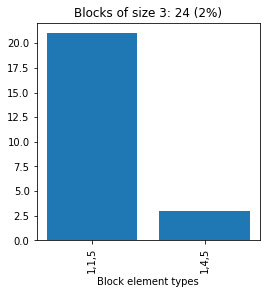

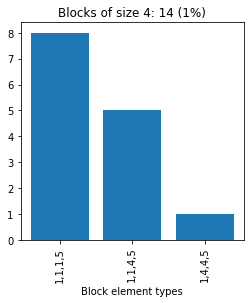

In [64]:
def plot_block_nelem(blocks_nelem):
    kv = list(blocks_nelem.items())
    xs = np.arange(len(kv))
    ys = np.array([v for k, v in kv])

    plt.bar(xs, ys)
    plt.xticks(xs, [k for k, v in kv], rotation=90)
    

for blocksize in range(1,5):
    sizes = [",".join(map(str, sg)) for sg in all_sgs if len(sg)==blocksize]
    blocks_nelem = Counter(sizes)
    print("{0}-element blocks".format(blocksize), blocks_nelem)
    plt.figure(figsize=(4,4))
    plt.title("Blocks of size {0}: {1} ({2:.0f}%)".format(blocksize, len(sizes), 100.0*len(sizes)/len(all_sgs)))
    plot_block_nelem(blocks_nelem)
    plt.xlabel("Block element types")

Look at the first 10 blocks.

In [ ]:
block_ids = data["element_block_id"]
inds_elem = np.arange(len(X))
inds_cand = np.arange(len(cands))
for blk in np.unique(block_ids)[:20]:
    candidates_from_block = data["candidate_block_id"] == blk
    elems_in_block = y == blk
    
    print("in block", blk, "had the following elements: {0}".format(get_types_in_block(X, y, blk)))
    for ielem in inds_elem[elems_in_block]:
        print("  elements[{0}]: type={1} energy={2:.2f}".format(ielem, int(X[ielem, 0]), X[ielem, 1]))
    print("from which the following candidates were produced")
    for icand in inds_cand[candidates_from_block]:
        print("  candidates[{0}]: pdgid={1} pt={2:.2f}".format(icand, int(cands[icand, 0]), cands[icand, 1]))
    print()